##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transferência de aprendizado com TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />Ver em TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Executar no Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Ver código fonte no GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/pt-br/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Baixar notebook</a>
  </td>
</table>

O [TensorFlow Hub] (http://tensorflow.org/hub) é uma maneira de compartilhar componentes de modelo pré-treinados. Consulte o [TensorFlow Module Hub] (https://tfhub.dev/) para obter uma lista pesquisável de modelos pré-treinados. Este tutorial demonstra:

1. Como usar o TensorFlow Hub com o `tf.keras`.
1. Como fazer a classificação da imagem usando o TensorFlow Hub.
1. Como fazer um simples aprendizado de transferência.

## Configuração

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow as tf

/bin/bash: pip: comando não encontrado


In [3]:
!pip install -q -U tf-hub-nightly
!pip install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

/bin/bash: pip: comando não encontrado
/bin/bash: pip: comando não encontrado


## Um Classificador ImageNet

### Baixar o classificador

Use `hub.module` para carregar uma mobilenet e `tf.keras.layers.Lambda` para envolvê-la como uma camada keras. Qualquer [URL do classificador de imagem compatível com TensorFlow 2] (https://tfhub.dev/s?q=tf2&module-type=image-classification) do tfhub.dev funcionará aqui.


In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Execute-o em uma única imagem

Faça o download de uma única imagem para experimentar o modelo.

73728/61306 [====================================] - 0s 2us/step


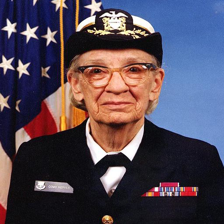

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Adicione uma dimensão em batch e passe a imagem para o modelo.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

O resultado é um vetor de 1001 elementos de logits, classificando a probabilidade de cada classe para a imagem.

Portanto, o ID da classe superior pode ser encontrado com argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decodificar as previsões

Temos o ID da classe previsto,
Busque as etiquetas `ImageNet` e decodifique as previsões

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 1us/step


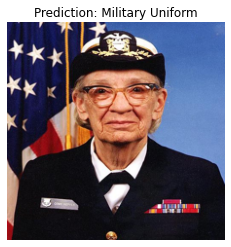

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Transferência de aprendizado simples

Usando o TF Hub, é simples treinar novamente a camada superior do modelo para reconhecer as classes em nosso conjunto de dados.

### Conjunto de Dados

Neste exemplo, você usará o conjunto de dados de flores TensorFlow:

In [12]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

A maneira mais simples de carregar esses dados em nosso modelo é usando `tf.keras.preprocessing.image.ImageDataGenerator`,

Todos os módulos de imagem do TensorFlow Hub esperam entradas flutuantes na faixa `[0,1]`. Use o parâmetro `rescale` do `ImageDataGenerator` para conseguir isso.

O tamanho da imagem será tratado posteriormente.

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


O objeto resultante é um iterador que retorna os pares `image_batch, label_batch`.

In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Rode o classificador em um lote de imagens

Agora, execute o classificador em um lote de imagens.

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'daisy', 'picket fence', 'cardoon', 'bee', 'crane',
       'daisy', 'daisy', 'pot', 'ear', 'bee', 'vase', 'daisy', 'pot',
       'daisy', 'barn spider', 'cardoon', 'daisy', 'daisy', 'earthstar',
       'velvet', 'daisy', 'picket fence', 'vase', 'daisy', 'daisy',
       'daisy', 'daisy', 'hip', 'picket fence', "yellow lady's slipper",
       'daisy'], dtype='<U30')

Agora verifique como essas previsões estão alinhadas com as imagens:

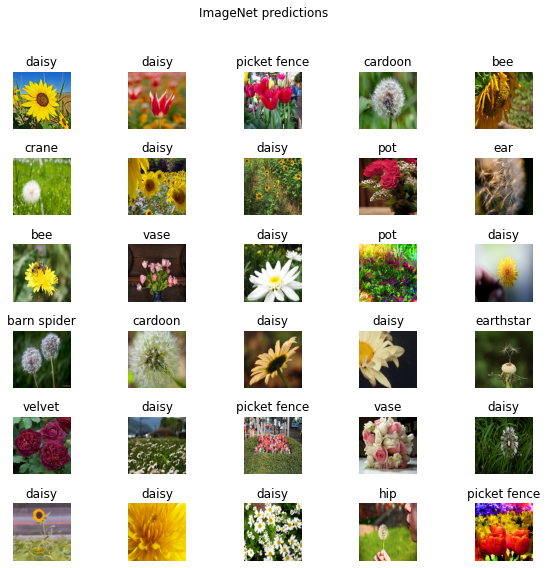

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Veja o arquivo `LICENSE.txt` para atribuições de imagem.

Os resultados estão longe de serem perfeitos, mas razoáveis, considerando que essas não são as classes para as quais o modelo foi treinado (exceto "daisy").

### Faça o download do modelo sem cabeça

O TensorFlow Hub também distribui modelos sem a camada de classificação superior. Eles podem ser usados para transferir facilmente o aprendizado.

Qualquer [URL do vetor de recurso de imagem compatível com Tensorflow 2] (https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) do tfhub.dev funcionará aqui.

In [18]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Crie o extrator de características.

In [19]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

Isto retorna um vetor de tamanho 1280 para cada imagem:

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Congele as variáveis na camada extrator de característica, para que o treinamento modifique apenas a nova camada do classificador.

In [21]:
feature_extractor_layer.trainable = False

### Anexar um cabeçalho de classificação

Agora envolva a camada do hub em um modelo `tf.keras.Sequential` e adicione uma nova camada de classificação.

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
_________________________________________________________________
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

### Treine o Modelo

Use compile para configurar o processo de treinamento:

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Agora use o método `.fit` para treinar o modelo.

Para manter este exemplo, treine apenas duas épocas. Para visualizar o progresso do treinamento, use um retorno de chamada personalizado para registrar a perda e a acurácia de cada lote individualmente, em vez da média da época.

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

<ipython-input-27-dd38f4e8ca03>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data, epochs=2,


Epoch 1/2
115/115 [==============================] - 75s 624ms/step - loss: 0.4756 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 73s 636ms/step - loss: 0.4448 - acc: 0.8750


Agora, depois de apenas algumas iterações de treinamento, já podemos ver que o modelo está progredindo na tarefa.

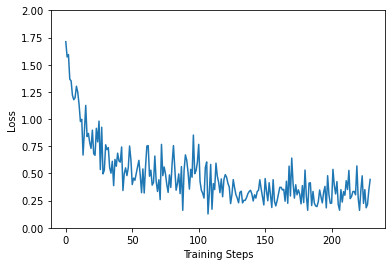

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

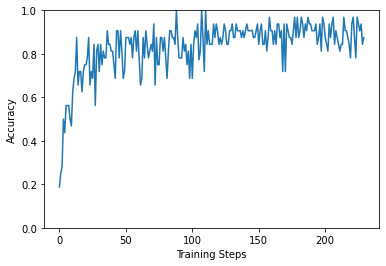

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Verificando as previsões

Para refazer a plotagem de antes, primeiro obtenha a lista ordenada de nomes de classe:

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Execute o lote de imagens através do modelo e converta os índices em nomes de classe.

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plote o resultado

In [32]:
label_id = np.argmax(label_batch, axis=-1)

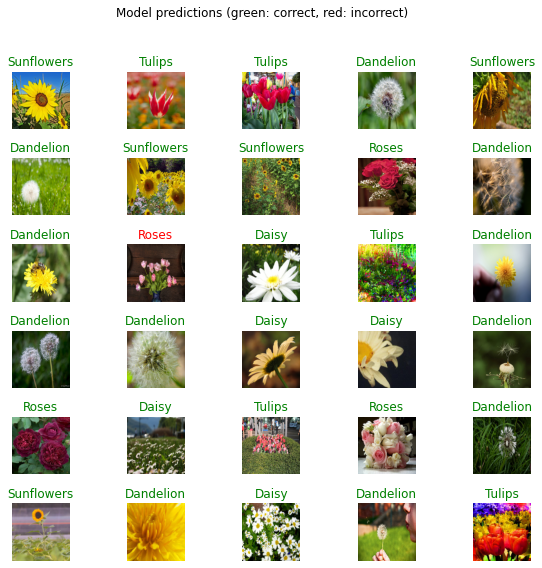

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Exporte seu modelo

Agora que você treinou o modelo, exporte-o como um modelo salvo:

In [34]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1631415272/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1631415272/assets


'/tmp/saved_models/1631415272'

Agora confirme que podemos recarregá-lo e ainda dá os mesmos resultados:

In [35]:
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0

Este modelo salvo pode ser carregado para inferência posteriormente ou convertido para [TFLite] (https://www.tensorflow.org/lite/convert/) ou [TFjs] (https://github.com/tensorflow/tfjs-converter).
